In [1]:
from ocr_processing import ocr_processing
from langgraph.graph import END, StateGraph, START
from typing_extensions import TypedDict
from typing import List
from langchain_core.prompts import ChatPromptTemplate
import weaviate, os
import openai
# from langchain_core.output_parsers import StrOutputParser
# from langchain_anthropic import ChatAnthropic
start_page, end_page= 1, 10
# claude_api_key=""
# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620",api_key=claude_api_key)
weaviate_client = weaviate.Client("http://192.168.0.202:8080") 
class GraphState(TypedDict):
    question : str
    file_name : str
    class_name : str
    retrieve_res: List[dict]
    response: str
    annotations: List[dict]

def pdf_processing(state):
    print(state)
    global start_page
    global end_page
    print("--- PDF processing ---")
    question = state["question"]
    file_name = state["file_name"]
    class_name=ocr_processing(file_name,start_page, end_page)
    return {"question": question, "file_name":file_name, "class_name":class_name}

        
def get_embedding(text, engine="text-embedding-3-large") : 
    Openai_API_KEY = ""
    os.environ["OPENAI_API_KEY"] =  Openai_API_KEY
    openai.api_key =os.getenv("OPENAI_API_KEY")

    # res = openai.Embedding.create(input=text,engine=engine)['data'][0]['embedding']
    from openai import OpenAI
    embedding_client = OpenAI()
    res= embedding_client.embeddings.create(input = text, model=engine).data[0].embedding
    return res
    
def retrieve(state):
    print(state)
    global weaviate_client
    print("--- RETRIEVE from Vector Store DB ---")
    question = state["question"]
    file_name = state["file_name"]
    weaviate_class = state["class_name"]
    property_list = list(map(lambda x: x["name"], weaviate_client.schema.get(weaviate_class)['properties']))
    query_vector = get_embedding(question)
    documents = weaviate_client.query.get(weaviate_class, property_list).with_hybrid(question, vector=query_vector).with_limit(3).do()
    retrieve_res=list(map(lambda x: x["content"], documents["data"]["Get"][weaviate_class.title()]))
    annotations=list(map(lambda x: {"page_num":x["page_num"],"bbox":x["bbox"].split("//"), "box_color":x["box_color"].split("//")}, documents["data"]["Get"][weaviate_class.title()]))
    return {"question": question, "file_name":file_name, "class_name":weaviate_class, "retrieve_res": retrieve_res, "annotations":annotations}

Openai_API_KEY = ""
from openai import OpenAI
llm_client = OpenAI(api_key=Openai_API_KEY)

def get_summary_response(text,documents):
    gpt_prompt=f"""You are a highly knowledgeable and friendly chatbot designed to answer questions based on a provided document about prompt engineering. 
    The document includes information on various aspects of prompt engineering, such as techniques, strategies, use cases, and best practices.
    When a user asks a question, your goal is to provide accurate, concise, and contextually relevant answers based on the document. 
    If the document contains multiple sections that could answer the question, summarize the relevant sections.
    Question: {text}
    
    Here is the document content for reference:
    {documents}

    Guidelines:
    - Refer to the above document and write the answer to the user's question in Korean. All responses must be given in Korean.
    - Always refer to the document content for your answers.
    - Provide clear and concise explanations.
    - If a question is not directly answerable from the document, acknowledge the limitation and suggest consulting the full document for detailed information.

    """
    # response = openai.ChatCompletion.create(
    response = llm_client.chat.completions.create(
        model="gpt-4o",
        # api_key=Openai_API_KEY,
        messages=[{"role": "system", "content": gpt_prompt}],
        max_tokens=1024)
    return response.choices[0].message.content

def generate(state):
    print("--- GENERATE Answer ---")
    question = state["question"]
    file_name = state["file_name"]
    weaviate_class = state["class_name"]
    retrieve_res=state["retrieve_res"]
    annotations=state["annotations"]
    generation= get_summary_response(question,retrieve_res)
    return {"question": question, "file_name":file_name, "class_name":weaviate_class, "retrieve_res": retrieve_res, "annotations":annotations, "response":generation}


/usr/local/lib/python3.9/dist-packages/weaviate/warnings.py:162: DeprecationWarning: Dep016: Python client v3 `weaviate.Client(...)` connections and methods are deprecated. Update
            your code to use Python client v4 `weaviate.WeaviateClient` connections and methods.

            For Python Client v4 usage, see: https://weaviate.io/developers/weaviate/client-libraries/python
            For code migration, see: https://weaviate.io/developers/weaviate/client-libraries/python/v3_v4_migration
            
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/weaviate/warnings.py:162: DeprecationWarning: Dep016: Python client v3 `weaviate.Client(...)` connections and methods are deprecated. Update
            your code to use Python client v4 `weaviate.WeaviateClient` connections and methods.

            For Python Client v4 usage, see: https://weaviate.io/developers/weaviate/client-libraries/python
            For code migration, see: https://weaviate.io/developers/weaviate/cl

In [2]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("pdf_processing", pdf_processing)
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("generate", generate)

workflow.add_edge(START, "pdf_processing")
workflow.add_edge("pdf_processing", "retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# Build graph
# workflow.set_conditional_entry_point(
#     pdf_processing, 
#     {
#         "pdf processing done": "retrieve", #returns of the function
#         "end": END #returns of the function
#     },
# )

app = workflow.compile()

In [3]:
inputs = {"file_name": '세로형PDF_(20240603) 금융시장 브리프',"question":"5월 금융시장 동향에 대해 알려줘"}
# for output in app.stream(inputs):
#     for key, value in output.items():
#         pprint(f"Finished running: {key}:")
# print(value["generation"])
res=app.invoke(inputs)
res

{'question': '5월 금융시장 동향에 대해 알려줘', 'file_name': '세로형PDF_(20240603) 금융시장 브리프', 'class_name': None, 'retrieve_res': None, 'response': None, 'annotations': None}
--- PDF processing ---
--- check DB ---
--- PDF exist, calss name: ['ocr']---
{'question': '5월 금융시장 동향에 대해 알려줘', 'file_name': '세로형PDF_(20240603) 금융시장 브리프', 'class_name': 'ocr', 'retrieve_res': None, 'response': None, 'annotations': None}
--- RETRIEVE from Vector Store DB ---
--- GENERATE Answer ---


{'question': '5월 금융시장 동향에 대해 알려줘',
 'file_name': '세로형PDF_(20240603) 금융시장 브리프',
 'class_name': 'ocr',
 'retrieve_res': ['가운데,국내증시는수출호조에따른제조업실적개선에힘입어추가상승할전망\n[금리]\n 양호한 1분기 경기여건과 더딘 물가 둔화로 금리인하 필요성이 축소됨에 따라 한·미\n기준금리 인하시점은 올해 3~4분기로 지연되고 인하폭도 25bp에 그칠 전망\n- 4월 소비자물가·고용지표 둔화에도 불구하고, 전반적으로 양호한 미국 경기여건과 \n연준 인사들의 매파적 스탠스 유지 등을 감안할 때 연준의 금리인하는 올해 9월 \n한차례에 그칠 것으로 예상(6.11~12일 FOMC 회의 기준금리 동결 전망)\n* CMEFedWatch는미연준의금리인하가올해9월(5.28일기준57.4%)25bp1차례에\n그치고,다음인하시점은25.1월(77.4%)로미뤄질확률을높게반영\n- 부동산 PF 부실 등에 따른 내수부진 우려에도 불구하고, 미 연준의 조기 금리인하 \n기대 약화, 예상을 상회한 1분기 GDP, 원화 약세 부담 등을 고려하여 한국은행도 기준금리 \n인하시점을 올해 4분기까지 늦출 것으로 전망\n* 금통위직후발간된7개IB보고서를종합하면향후금리인하시점은4분기(4개IB)가\n3분기(3개)보다가능성이높은것으로평가\n 국고채 금리는 미국 4월 PCE 물가와 5월 고용지표, 6.11~12일 FOMC에 대한 경계로 \n하방경직성을 보이겠으나, 금리 상승 시 저가 대기 매수세도 여전하여 기준금리 \n레벨(10년물 3.55%, 3년물 3.45%)을 중심으로 제한된 범위의 등락이 예상\n* 국고채3년물금리전망(기말,%):24.4월3.53→5월3.45→6월F3.45\n* 미국4월PCE물가상승률(yoy)은2.7%로시장예상치에부합(근원물가는+2.8%)\n선\n물시장\n에반영된\n연\n준기준금\n리전망\n한국소비자물가상승률,기준금리',
  '가운데,국내증시는수출호조에따른제조업실적개선에힘입어추가상승할전망\

In [5]:
retreival_res = {
    "response": res["response"],
    "annotations": res["annotations"]
}

In [19]:
bboxes={}
for ra in retreival_res["annotations"]:
    bbox=list(map(lambda x : float(x),ra["bbox"]))
    box_color=tuple(map(lambda x : int(x),ra["box_color"]))
    if ra["page_num"] not in list(bboxes.keys()):
        bboxes[ra["page_num"]]=[{"bbox":bbox, "box_color":box_color}]
    else:bboxes[ra["page_num"]].append({"bbox":bbox, "box_color":box_color})

In [20]:
bboxes

{8: [{'bbox': [91.78765880217784,
    165.89687633718444,
    524.449485783424,
    556.7081728712025],
   'box_color': (0, 255, 0)},
  {'bbox': [91.78765880217784,
    165.89687633718444,
    524.449485783424,
    556.7081728712025],
   'box_color': (0, 255, 0)}],
 3: [{'bbox': [92.50756200846945,
    177.4124946512623,
    522.2897761645493,
    365.6208814719726],
   'box_color': (0, 255, 0)}]}

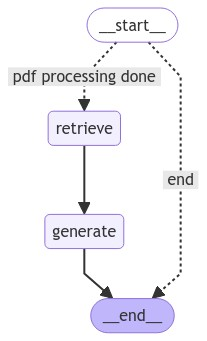

In [56]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
# print(app.get_graph().draw_mermaid())
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)